WHAT WE WILL DO:

1. implement a deep autoencoder and encoder model with PyTorch (with agnostic code)
2. train the autoencoder with MNIST dataset
3. save and load the parameters of our model
4. extract only the encoder parameters from the trained autoencoder -> trained encoder for dimensionality reduction ecc...

In [10]:
import torch
from torchvision import datasets
import torchvision 
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [11]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device choosen: {}'.format(device))

# Setup random seed
RANDOM_SEED = 42

device choosen: cuda


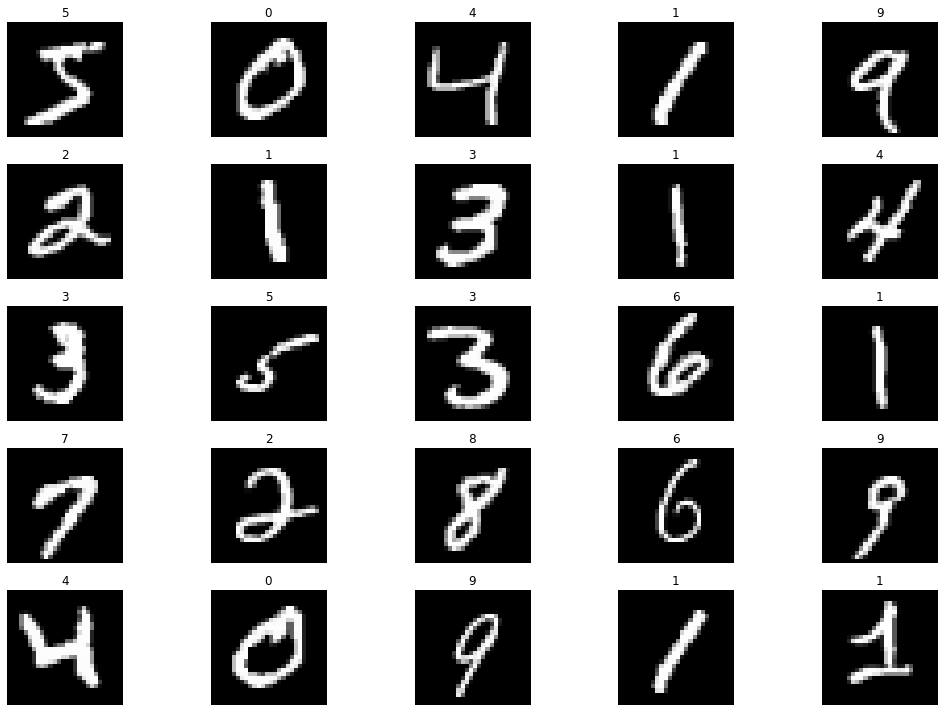

In [12]:
plt.rcParams['figure.figsize'] = 15, 10
  
# Initializing the transform for the dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5), (0.5))
])
  
# Downloading the MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root="./MNIST/train", train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True)
  
test_dataset = torchvision.datasets.MNIST(
    root="./MNIST/test", train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True)
  
# Creating Dataloaders from the
# training and testing dataset
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=256)
  
# Printing 25 random images from the training dataset
random_samples = np.random.randint(
    1, len(train_dataset), (25))
  
for idx in range(random_samples.shape[0]):
    plt.subplot(5, 5, idx + 1)
    plt.imshow(train_dataset[idx][0][0].numpy(), cmap='gray')
    plt.title(train_dataset[idx][1])
    plt.axis('off')
  
plt.tight_layout()
plt.show()

In [19]:
# Creating a DeepAutoencoder class
class DeepAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10)
        )
          
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 28 * 28),
            torch.nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Creating a DeepEncoder class
class DeepEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10)
        )

  
    def forward(self, x):
        encoded = self.encoder(x)
        return encoded
  
# Instantiating the model and hyperparameters
model = DeepAutoencoder().to(device)

In [20]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [22]:
def training_loop(model, train_loader):

  ###Training
  model.train()
  
  # Initializing variable for storing loss
  running_trainining_loss = 0
    
  # Iterating over the training dataset
  for batch in train_loader:
      
      # Loading image(s) and
      # reshaping it into a 1-d vector
      img, _ = batch 
      img = img.reshape(-1, 28*28).to(device) 
        
      # Generating output
      out = model(img)
        
      # Calculating loss
      loss = loss_fn(out, img)
          
      # Updating weights according
      # to the calculated loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
        
      # Incrementing loss
      running_trainining_loss += loss.item()

  # Averaging out loss over entire batch
  running_trainining_loss /= batch_size
  avg_train_loss = running_trainining_loss

  img_dict = {'img': img, 'out': out}

  return  model, avg_train_loss, img_dict

In [23]:
def evaluation_loop(model, my_loader):
  # Initializing variable for storing loss
  running_evaluation_loss = 0

  model.eval()
  with torch.inference_mode():
 
    # Iterating over the training dataset
    for batch in my_loader:
        
        # Loading image(s) and
        # reshaping it into a 1-d vector
        img, _ = batch  
        img = img.reshape(-1, 28*28).to(device)
          
        # Generating output
        out = model(img)
          
        # Calculating loss
        loss = loss_fn(out, img)
                  
        # Incrementing loss
        running_evaluation_loss += loss.item()

  # Averaging out loss over entire batch
  running_evaluation_loss /= batch_size
  avg_evaluation_loss = running_evaluation_loss

  return avg_evaluation_loss

In [24]:
torch.manual_seed(RANDOM_SEED)
# torch.cuda.manual_seed(RANDOM_SEED)

EPOCHS = 50

# List that will store the training loss
train_loss = []
test_loss = []
  
# Dictionary that will store the
# different images and outputs for 
# various epochs
outputs = {}
  
batch_size = len(train_loader)
  
# Training loop starts
for epoch in range(1,EPOCHS+1):
  
  ##  TRAINING LOOP
  model, running_trainining_loss, image_dict = training_loop(model, train_loader)
  ##  TESTING LOOP
  running_test_loss = evaluation_loop(model, test_loader)

  train_loss.append(running_trainining_loss)
  #test_loss.append(running_test_loss)
  print(f'epoch: {epoch} | loss: {running_trainining_loss:.5f} ')#| test loss: {running_test_loss:.5f}')

  # Storing useful images and
  # reconstructed outputs for the last batch
  outputs[epoch] = image_dict

epoch: 1 | loss: 0.07350 
epoch: 2 | loss: 0.04886 
epoch: 3 | loss: 0.03615 
epoch: 4 | loss: 0.02991 
epoch: 5 | loss: 0.02647 
epoch: 6 | loss: 0.02430 
epoch: 7 | loss: 0.02260 
epoch: 8 | loss: 0.02123 
epoch: 9 | loss: 0.02024 
epoch: 10 | loss: 0.01941 
epoch: 11 | loss: 0.01868 
epoch: 12 | loss: 0.01808 
epoch: 13 | loss: 0.01760 
epoch: 14 | loss: 0.01720 
epoch: 15 | loss: 0.01686 
epoch: 16 | loss: 0.01656 
epoch: 17 | loss: 0.01629 
epoch: 18 | loss: 0.01604 
epoch: 19 | loss: 0.01582 
epoch: 20 | loss: 0.01562 
epoch: 21 | loss: 0.01545 
epoch: 22 | loss: 0.01530 
epoch: 23 | loss: 0.01519 
epoch: 24 | loss: 0.01511 
epoch: 25 | loss: 0.01495 
epoch: 26 | loss: 0.01479 
epoch: 27 | loss: 0.01465 
epoch: 28 | loss: 0.01451 
epoch: 29 | loss: 0.01438 
epoch: 30 | loss: 0.01425 
epoch: 31 | loss: 0.01414 
epoch: 32 | loss: 0.01403 
epoch: 33 | loss: 0.01394 
epoch: 34 | loss: 0.01386 
epoch: 35 | loss: 0.01378 
epoch: 36 | loss: 0.01371 
epoch: 37 | loss: 0.01364 
epoch: 38 

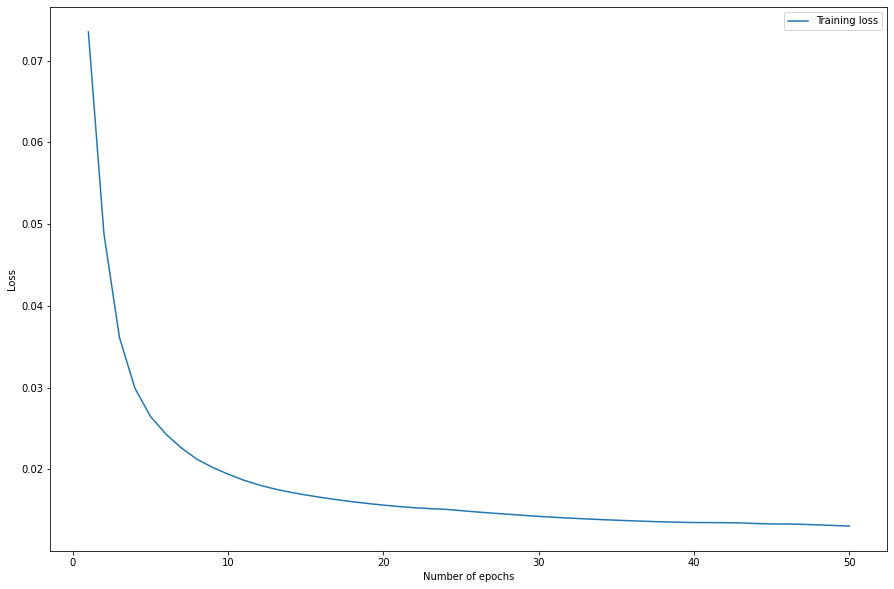

In [25]:
# Plotting the training loss
plt.plot(range(1,EPOCHS+1), train_loss, label='Training loss')
# plt.plot(range(1,EPOCHS+1), test_loss, label='Test loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

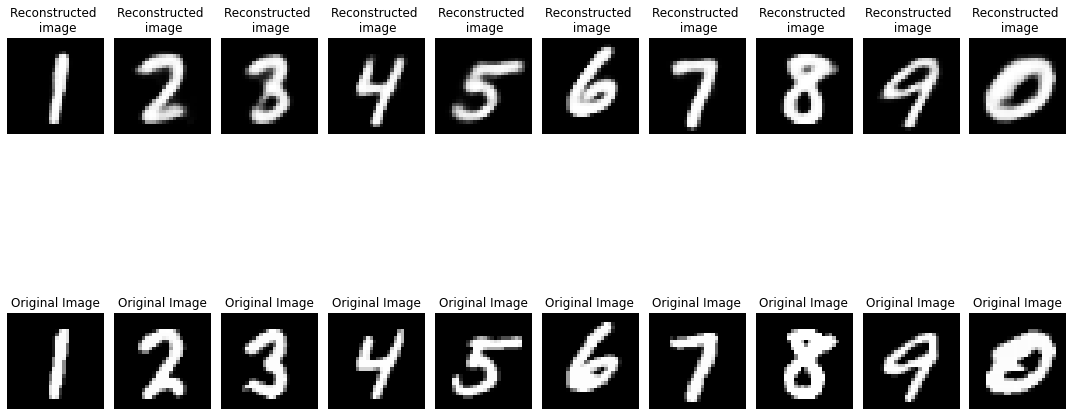

In [26]:
# Dictionary that will store the different
# images and outputs for various epochs
outputs = {}
  
# Extracting the last batch from the test 
# dataset
img, _ = list(test_loader)[-1]
  
# Reshaping into 1d vector
img = img.reshape(-1, 28 * 28).to(device)
  
# Generating output for the obtained
# batch
out = model(img)
  
# Storing information in dictionary
outputs['img'] = img
outputs['out'] = out
  
# Plotting reconstructed images
# Initializing subplot counter
counter = 1
val = outputs['out'].to('cpu')
val = val.detach().numpy()
  
# Plotting first 10 images of the batch
for idx in range(10):
    plt.subplot(2, 10, counter)
    plt.title("Reconstructed \n image")
    plt.imshow(val[idx].reshape(28, 28), cmap='gray')
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
  
# Plotting original images
  
# Plotting first 10 images
for idx in range(10):
    val = outputs['img']
    plt.subplot(2, 10, counter)
    plt.imshow(val[idx].reshape(28, 28).to('cpu'), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
  
plt.tight_layout()
plt.show()

In [27]:
# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "autoencoder_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)


Saving model to: models/autoencoder_model.pth


In [28]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model = DeepAutoencoder()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model.state_dict().keys()

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder.4.weight', 'encoder.4.bias', 'encoder.6.weight', 'encoder.6.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder.4.weight', 'decoder.4.bias', 'decoder.6.weight', 'decoder.6.bias'])

In [33]:
# Defining an encoder with only the first half of the autoencoder alreagy trained (and loaded)
my_Encoder = DeepEncoder()

# load what you can from the state_dict of Net1 with the command: Net2.load_state_dict(Net1.state_dict(),strict=False)
my_Encoder.load_state_dict(loaded_model.state_dict(),strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder.4.weight', 'decoder.4.bias', 'decoder.6.weight', 'decoder.6.bias'])

In [38]:
model.state_dict()['encoder.0.weight']

tensor([[-0.0174,  0.0210,  0.0315,  ...,  0.0085, -0.0182,  0.0344],
        [-0.0162,  0.0241,  0.0181,  ...,  0.0133, -0.0108, -0.0213],
        [ 0.0084, -0.0042, -0.0162,  ...,  0.0026,  0.0231,  0.0155],
        ...,
        [-0.0271, -0.0337, -0.0334,  ...,  0.0101,  0.0141, -0.0326],
        [ 0.0063,  0.0132, -0.0162,  ..., -0.0306, -0.0173,  0.0011],
        [ 0.0098,  0.0162, -0.0121,  ...,  0.0054, -0.0258, -0.0166]],
       device='cuda:0')

In [39]:
loaded_model.state_dict()['encoder.0.weight']

tensor([[-0.0174,  0.0210,  0.0315,  ...,  0.0085, -0.0182,  0.0344],
        [-0.0162,  0.0241,  0.0181,  ...,  0.0133, -0.0108, -0.0213],
        [ 0.0084, -0.0042, -0.0162,  ...,  0.0026,  0.0231,  0.0155],
        ...,
        [-0.0271, -0.0337, -0.0334,  ...,  0.0101,  0.0141, -0.0326],
        [ 0.0063,  0.0132, -0.0162,  ..., -0.0306, -0.0173,  0.0011],
        [ 0.0098,  0.0162, -0.0121,  ...,  0.0054, -0.0258, -0.0166]])

In [40]:
my_Encoder.state_dict()['encoder.0.weight']

tensor([[-0.0174,  0.0210,  0.0315,  ...,  0.0085, -0.0182,  0.0344],
        [-0.0162,  0.0241,  0.0181,  ...,  0.0133, -0.0108, -0.0213],
        [ 0.0084, -0.0042, -0.0162,  ...,  0.0026,  0.0231,  0.0155],
        ...,
        [-0.0271, -0.0337, -0.0334,  ...,  0.0101,  0.0141, -0.0326],
        [ 0.0063,  0.0132, -0.0162,  ..., -0.0306, -0.0173,  0.0011],
        [ 0.0098,  0.0162, -0.0121,  ...,  0.0054, -0.0258, -0.0166]])